# Why Julia is beautiful, but I probably will not switch from Python
*Where the sheer momentum of Python makes it hard for me to justify switching to Julia* 

[Julia](https://julialang.org/) has been on my radar since its inception. As early as 2013 [I gave Julia a quick try](https://www.r-bloggers.com/2013/12/julia-is-lightning-fast-bubble-sort-revisited/), and concluded the tool was very fast and cool, but not very mature in comparison to R. Although many years have passed, a quick [poll on my LinkedIn](https://www.linkedin.com/posts/paul-hiemstra-77030b20_ever-since-julia-stepped-out-onto-the-data-ugcPost-7033074528893173760-M0zC) showed that the tool was still very niche: 3 percent uses Julia as a secondary tool, only 2 percent uses Julia as their primary tool. The [TIOBE index confirms this](https://www.tiobe.com/tiobe-index/): Julia is in 33rd place behind other data science tools such as Python (1st), Matlab (12th), R (16th) and SAS (21nd). 

But sheer popularity is not all. I wanted to experience Julia in 2023 myself and assess how well it could work for me in my daily work. Some practical requirements in my daily work are:

- It has to run inside a container and VS Code
- Support for reading data from files: text files, CSV, Excel
- Support a dplyr like data flow where data and operations are chained top to bottom
- Support for a ggplot2 like plotting system
- Easily run basic ML algorithms: linear regression, Gradient Boosting, neural networks, etc

To assess the practicality of Julia I decided to reimplement the workflow I used in [one my recent articles](https://medium.com/towards-data-science/does-my-new-central-heating-boiler-help-with-these-crazy-high-gas-prices-b238fd623bba). All my code and the development environment can be found on [the github page of this article](https://github.com/PaulHiemstra/eval_julia). Of particlar interest are the environment files ([devcontainter](https://github.com/PaulHiemstra/eval_julia/blob/main/.devcontainer.json), [docker](https://github.com/PaulHiemstra/eval_julia/blob/main/docker/Dockerfile)) and [a code notebook](https://github.com/PaulHiemstra/eval_julia/blob/main/replicate_gas_usage_article.ipynb). 

# Creating the development environment
Unexpectedly, setting up the code environment the way I wanted turned out to be tricky. I first tried to look for a pre-built data science container that included Julia and all the tools I needed. I ended up trying [this container](https://github.com/jupyter/docker-stacks/tree/main/datascience-notebook), but ran into Jupyter server issues with VS Code. The issue was that this container launched its own Jupyter server, which I could not get working with VS Code. I could launch a Jupyter server from `.devcontainer.json` like I was used to, but this would make the experience very unstable with regularly crashes of the dev container. 

Next I tried to install Julia inside an Anaconda3 container, which includes tooling such as Jupyter out of the box. But simply installing Julia using `conda` simply did not work for me. After much tinkering, I ended up taking the approach from the container I tried earlier and downloaded the relevant Julia binaries from inside the container. I grabbed the code for this from the [docker file of that project](https://github.com/jupyter/docker-stacks/blob/main/datascience-notebook/Dockerfile). In addition to the core Julia binaries, I also installed a number of additional packages that added functionality I needed:

- [`StatsKit`](https://github.com/JuliaStats/StatsKit.jl), provides a meta-package that allows us to quickly load a great number of statistical packages in one go. 
- [`Chain`](https://github.com/jkrumbiegel/Chain.jl) provides the `@chain` macro, which has some added benefits over the default pipes in Julia.
- [`DataFramesMeta`](https://juliadata.github.io/DataFramesMeta.jl/stable/), provides a `dplyr` like interface for [`DataFrames.jl`](https://dataframes.juliadata.org/stable/) which in turn provides a DataFrame-like experience inspired by R's dataframes. A more 1:1 implementation of `dplyr`, [`Tidier.jl`](https://github.com/kdpsingh/Tidier.jl), has been gaining popularity and is defintely worth having a look at. 
- [`Gadfly`](http://gadflyjl.org/stable/), provides a plotting package that is based on a grammar of graphics just like `ggplot2`. 
- [`Dates`](https://docs.julialang.org/en/v1/stdlib/Dates/) provides the datatypes needed to work with dates. 
- [`XLSX`](https://felipenoris.github.io/XLSX.jl/stable/) allows reading Excel files from disk. 
- [`GLM`](https://juliastats.org/GLM.jl/stable/) implements linear and generalized linear models in Julia. 

In general, I'm quite happy with the development environment I ended up with. It did however take a lot of time to setup, which might be an issue for people who just want to get work done. Data science in Python just does not have this kind of headache: grab an Anaconda3 container and you are off to the races. In addition, in my current setup Julia precompiles packages the first time they are called. This can take quite some time (~20 sec), and that it has to be done again after restarting the kernel makes it even more of a hassle. The new version of Julia supposedly fixes the need for precompilation, so this might not be an issue in the future. 

# Actually writing Julia code
With our development environment setup, we can actually start writing code. I chose to reproduce the [gas usage article](https://medium.com/towards-data-science/does-my-new-central-heating-boiler-help-with-these-crazy-high-gas-prices-b238fd623bba) I wrote earlier. It analyzes my gas usage to assess wheter or not my new boiler uses less gas. In the sections below I will show how I used Julia, and provide some comments on how I liked the experience. 

First we read the temperature data from the text file, and resample it to a weekly average:

In [1]:
using StatsKit, DataFramesMeta, Dates, Gadfly, XLSX, GLM

knmi_data = @chain "knmi_weather.txt" begin
    CSV.File(comment="#", header=["station", "Datum", "T_avg", "T_min", "T_max"], 
             dateformat="yyyymmdd", types=Dict(:Datum => Date))   
    DataFrame()
    @transform(:T_avg = :T_avg / 10, :T_min = :T_min / 10, :T_max = :T_max / 10,     # Temp data was stored as 0.1 deg integer values
               :week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :T_avg=mean(:T_avg),          # Aggregate to week
                              :Datum=:Datum[1])             # Append the first date of the week
end

first(knmi_data, 3)

Row,week_id,year_id,T_avg,Datum
,Int64,Int64,Float64,Date
1,1,2014,6.0875,2014-01-01
2,1,2015,4.625,2015-01-01
3,1,2016,0.671429,2016-01-04


I am quite happy with the `dplyr` like style using `@chain`, and the syntax feels alot more consistent than I am used to with Pandas. In addition, the `CSV` package works fine and I am able to easily resample the dataset. However, I have not been able to find something akin to `df.resample('W')` from Pandas, which works even better than the resampling approach I take in the code above. 

Next, we load the gas usage data from the Excel file, resample the usage to weekly sums and join the data to the temperature data we read earlier:

In [2]:
joined_weekly_mean = @chain "usage_anonymized.xlsx" begin
    XLSX.readtable("Sheet1", infer_eltypes = true)
    DataFrame()
    @transform(:week_id = Dates.week.(:Datum),
               :year_id = Dates.year.(:Datum))
    @by([:week_id, :year_id], :gas_usage=sum(:gas_usage),   # Aggregate to week
                              :Datum=:Datum[1],             # Append the first date of the week
                              :no_days=size(:Datum)[1])     # Append number of days present in this week
    innerjoin(knmi_data, on=:Datum, makeunique=true)
    @subset(:gas_usage .>= 0.55, :no_days .== 7)            # Eliminate some obvious faulty values and weeks that do not have the full 7 days
    @transform(:post_install = :Datum .> Date("2022-05"))
end

first(joined_weekly_mean, 3)

Row,week_id,year_id,gas_usage,Datum,no_days,week_id_1,year_id_1,T_avg,post_install
,Int64,Int64,Float64,Date,Int64,Int64,Int64,Float64,Bool
1,1,2016,3.61538,2016-01-04,7,1,2016,0.671429,false
2,1,2017,3.84615,2017-01-02,7,1,2017,1.21429,false
3,1,2021,3.0,2021-01-04,7,1,2021,1.57143,false


Again, Julia works very well. For example, creating `post_install` using `@transform` was really easy. To be true, having a fully functional `transform` implementation that works without `lambda` functions and allows you to reuse columns created in the same `transform` call is a really nice change from `Pandas`. 

With the data loaded, we can visualise the weekly aggregated data:

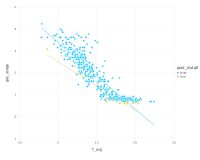

In [5]:
set_default_plot_size(20cm, 16cm)
@chain joined_weekly_mean begin
    Gadfly.plot(x=:T_avg, y=:gas_usage, color=:post_install, Geom.point, Geom.smooth(method=:lm))
end

`Gadfly` works well enough, but the syntax is quite different from what I am used to from R and plotnine. For example, the code needed to produce the image above in the ggplot2 style I use:

In [ ]:
(
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage')) 
      + geom_point()
      + geom_smooth(method='lm')
)

The approach `plotnine` takes suits me better as it copies the syntax of `ggplot2` as is. In addition to syntax, Gadfly also has some missing functionality such as `facet_wrap`. In addition, I was used to saving plots using `ggsave` and for it to simply work. When trying to do the same for Gadfly I had to install a number of additional packages, and it still did not work after that. These kind of minor differences make the transition much harder: why would I switch to Gadfly when `ggplot2` and `plotnine` already serve my needs perfectly?

Next we fit the linear model:

In [2]:
lm(@formula(gas_usage ~ T_avg * post_install), joined_weekly_mean)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gas_usage ~ 1 + T_avg + post_install + T_avg & post_install

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            3.39368    0.041646     81.49    <1e-99   3.31183     3.47554
T_avg                 -0.152191   0.00350507  -43.42    <1e-99  -0.15908    -0.145302
post_install          -0.889057   0.183482     -4.85    <1e-05  -1.24969    -0.528424
T_avg & post_install   0.0421465  0.0129811     3.25    0.0013   0.0166322   0.0676607
──────────────────────────────────────────────────────────────────────────────────────

which works splendidly, exactly as I remember it from R using the formula-style interface. 

# Beyond regression
The analysis above uses basic linear models, but my work requires me to have access to a broader set of tools. Due to time constraints I did not implement more models, but some googling did reveal that most of your analysis needs will be met. For example, [a port of xgboost](https://github.com/dmlc/XGBoost.jl) is available in Julia, as are [wrappers for CatBoost](https://github.com/JuliaAI/CatBoost.jl). A potential downside is that although neural networks are present in Julia, their implementation seems to be somewhat more barebones than I am used to in Python/Keras. For example, the code in [this article](https://towardsdatascience.com/the-future-of-machine-learning-and-why-it-looks-a-lot-like-julia-a0e26b51f6a6) suggests to me that grabbing pre-trained models from the internet is quite a hassle. This is however in contrast to the [`EfficientNet.jl`](https://github.com/pxl-th/EfficientNet.jl) package which seems to be alot more straightforward. Do note that I have not invested a lot of time in neural nets in Julia, so I can only provide my first impression. 

# So, will I switch? 
I have really enjoyed my time with Julia. I really like the consistent syntax, which is something that Pandas and Data Science in Python as a whole is weaker at. In addition, it seems that much of the analysis tools that one would need are readily available in Julia. One of the big advantages that Julia touts is its speed. To be honest, using these basic tools and quite a small dataset I did not notice a huge difference in speed. In addition, I do not care that much that pure Julia is faster than pure Python, the majority of the tools do not run in pure Python/Julia but provide wrappers around C++, Fortran or some other very fast language. 

To be honest, in a vacuum my preference would be to switch to Julia. However, we do not live in a vacuum. Showstoppers for Julia for me include:

- I already know Python, every second I spend relearning tasks in Julia is time wasted. 
- All my co-workers and students work in Python, so any Julia work I do cannot be shared with them easily
- For students, DS in Python is a much more marketable skill as not a lot of companies are looking for Julia devs. This advantage becomes even stronger if you realise Python is used for a lot more than just data science. 
- The community around DS for Python is a lot bigger. This means more mature packages, a lot more tutorials, and a larger chance someone in your company can help you out. This problem is even worse for novice users. 

So, it pains me to say that the sheer momentum of Python makes it very hard for me to switch to Julia. Python here joins the ranks of JavaScript to show that the most popular tool is not necessarily the best tool. 

What do you think? Are you considering a switch to Julia? 